In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import functional as F

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
    
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
cwd = os.getcwd()
store_TG_TN_TX_RR_HU_PP = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-tg-tn-tx-rr-hu-pp.zarr'
ds_multi = xr.open_dataset(store_TG_TN_TX_RR_HU_PP, engine='zarr', chunks={})

store_SURFACE_DOWNWELLING = 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/EOBS-feedstock/eobs-surface-downwelling.zarr'
ds_rad = xr.open_dataset(store_SURFACE_DOWNWELLING, engine='zarr', chunks={})

In [4]:
def check_data_info():
    print("time serial:")
    print("*" * 40)
    print(f"multi_time from: {ds_multi.time.min().values} to {ds_multi.time.max().values}")
    print(f"radation_time from: {ds_rad.time.min().values} to {ds_rad.time.max().values}")
    
    print("spatial:")
    print("*" * 40)
    print(f"multi_latitude from: {ds_multi.latitude.min().values:.2f} to {ds_multi.latitude.max().values:.2f}")
    print(f"multi_longitude from: {ds_multi.longitude.min().values:.2f} to {ds_multi.longitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.latitude.min().values:.2f} to {ds_rad.latitude.max().values:.2f}")
    print(f"radiation_latitude from: {ds_rad.longitude.min().values:.2f} to {ds_rad.longitude.max().values:.2f}")

check_data_info()

time serial:
****************************************
multi_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
radation_time from: 1950-01-01T00:00:00.000000000 to 2020-12-31T00:00:00.000000000
spatial:
****************************************
multi_latitude from: 25.05 to 71.45
multi_longitude from: -24.95 to 45.45
radiation_latitude from: 25.05 to 70.95
radiation_latitude from: -24.95 to 44.95


In [5]:
def normalize_data(data, mean=None, std=None):
    if mean is None:
        mean = np.nanmean(data, axis=(0, 2, 3), keepdims=True)
        std = np.nanstd(data, axis=(0, 2, 3), keepdims=True)
        std = np.where(std == 0, 1.0, std)
    
    normalized = (data - mean) / std
    
    normalized = np.nan_to_num(normalized, nan=0.0)
    
    return normalized, mean, std

In [6]:
#time from 1950 to 2020
#latitude from 25 to 69(X)
#longitude form -24 to 44(X)
#train=80%(20% in val_dataset) test=20% 


#since the datas on the ocean range are NaN, So I choose Hungary(latitude from 45 to 49 and longitude from 16 to 23) to train 



def prepare_cnn_data(ds_multi, ds_rad, 
                    lat_range=(45, 49), 
                    lon_range=(16, 23),
                    train_ratio=0.8,
                    val_ratio=0.8,
                    time_sample_freq=365,
                    batch_size=32):

    ds_multi = ds_multi.sortby("time")
    ds_rad   = ds_rad.sortby("time")


    _, idx_multi = np.unique(ds_multi.time.values, return_index=True)
    ds_multi = ds_multi.isel(time=idx_multi)

    _, idx_rad = np.unique(ds_rad.time.values, return_index=True)
    ds_rad = ds_rad.isel(time=idx_rad)


    common_time = np.intersect1d(ds_multi.time.values, ds_rad.time.values)
    ds_multi = ds_multi.sel(time=common_time)
    ds_rad   = ds_rad.sel(time=common_time)


 
    ds_multi = ds_multi.sel(time=slice("1950-05-01", "2020-12-31")) #approperite date
    ds_rad   = ds_rad.sel(time=slice("1950-05-01", "2020-12-31"))   #approperite date


    print(f"   spatial range: latitude {lat_range}, longitude {lon_range}")
    print(f"   time sample frequency: {time_sample_freq}")


    bbox_multi = ds_multi.where(
        (ds_multi.latitude >= lat_range[0]) & 
        (ds_multi.latitude <= lat_range[1]) &
        (ds_multi.longitude >= lon_range[0]) &
        (ds_multi.longitude <= lon_range[1]),
        drop=True
    )
    
    bbox_rad = ds_rad.where(
        (ds_rad.latitude >= lat_range[0]) & 
        (ds_rad.latitude <= lat_range[1]) &
        (ds_rad.longitude >= lon_range[0]) &
        (ds_rad.longitude <= lon_range[1]),
        drop=True
    )


    #interpoation
    bbox_multi = bbox_multi.interpolate_na(dim="latitude", method="linear")
    bbox_multi = bbox_multi.interpolate_na(dim="longitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="latitude", method="linear")
    bbox_rad   = bbox_rad.interpolate_na(dim="longitude", method="linear")


    bbox_multi_sampleed = bbox_multi.isel(time=slice(0, None, time_sample_freq))
    bbox_rad_sampleed   = bbox_rad.isel(time=slice(0, None, time_sample_freq))
    
    n_time = len(bbox_multi_sampleed.time)
    n_train = int(n_time * train_ratio)

    print('*'*50)
    print(f"   number of time samples: {n_time}")


    train_multi = bbox_multi_sampleed.isel(time=slice(0, n_train))
    test_multi  = bbox_multi_sampleed.isel(time=slice(n_train, None))

    train_rad = bbox_rad_sampleed.isel(time=slice(0, n_train))
    test_rad  = bbox_rad_sampleed.isel(time=slice(n_train, None))

    print('*'*50)
    print(f"   train samples: {len(train_multi.time)}")
    print(f"   test samples: {len(test_multi.time)}")

    print('*'*50)
    print('predictors: rr pp hu qq')
    print('predictand: tg')


    X_train_rr = train_multi['rr'].values.astype(np.float32)
    X_train_pp = train_multi['pp'].values.astype(np.float32)
    X_train_hu = train_multi['hu'].values.astype(np.float32)
    X_train_qq = train_rad['qq'].values.astype(np.float32)
    y_train    = train_multi['tg'].values.astype(np.float32)
    
    X_test_rr = test_multi['rr'].values.astype(np.float32)
    X_test_pp = test_multi['pp'].values.astype(np.float32)
    X_test_hu = test_multi['hu'].values.astype(np.float32)
    X_test_qq = test_rad['qq'].values.astype(np.float32)
    y_test    = test_multi['tg'].values.astype(np.float32)


    #y_train = np.nan_to_num(y_train, nan=0.0)
    #y_test  = np.nan_to_num(y_test,  nan=0.0)


    X_train_cnn = np.stack([X_train_rr, X_train_pp, X_train_hu, X_train_qq], axis=1)
    X_test_cnn  = np.stack([X_test_rr,  X_test_pp,  X_test_hu,  X_test_qq ], axis=1)


    X_train_norm, train_mean, train_std = normalize_data(X_train_cnn)
    X_test_norm,  _,          _         = normalize_data(X_test_cnn, train_mean, train_std)


    X_train_tensor = torch.FloatTensor(X_train_norm)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor  = torch.FloatTensor(X_test_norm)
    y_test_tensor  = torch.FloatTensor(y_test)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

    train_size = int(val_ratio * len(train_dataset))
    val_size   = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  pin_memory=True)
    val_loader   = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    data_dict = {
        'train_loader': train_loader,
        'val_loader':   val_loader,
        'test_loader':  test_loader,
        'input_shape': X_train_cnn.shape[1:],  
        'output_shape': y_train.shape[1:], 
        'time_train': train_multi.time.values,
        'time_test':  test_multi.time.values,
        'normalization': {
            'mean': train_mean,
            'std': train_std
        },
        'spatial_info': {
            'latitude': train_multi.latitude.values,
            'longitude': train_multi.longitude.values
        }
    }

    print('FINISH')
    return data_dict


In [7]:
data_dict = prepare_cnn_data(ds_multi, ds_rad)

   spatial range: latitude (45, 49), longitude (16, 23)
   time sample frequency: 365
**************************************************
   number of time samples: 71
**************************************************
   train samples: 56
   test samples: 15
**************************************************
predictors: rr pp hu qq
predictand: tg
FINISH


In [8]:
#test the data

def visualize_sample_data_separate():

    batch_X, batch_y = next(iter(data_dict['train_loader']))
    
    sample_X = batch_X[0]
    sample_y = batch_y[0]
    

    variables = ['RR (daily precipitation sum)', 'PP (daily mean sea-level pressure)', 
                 'HU (relative humidity)', 'QQ (global radiation)']
    cmaps = ['Blues', 'viridis', 'Greens', 'YlOrRd']
    units = ['mm', 'hPa', '%', 'W/m²']
    

    for i in range(4):
        plt.figure(figsize=(10, 6))
        im = plt.imshow(sample_X[i].cpu().numpy(), cmap=cmaps[i])
        plt.title(f'Input: {variables[i]}')
        plt.colorbar(im, label=units[i])
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.tight_layout()
        plt.show()
    

    plt.figure(figsize=(10, 6))
    im = plt.imshow(sample_y.cpu().numpy(), cmap='RdBu_r')
    plt.title('Output: TG (daily mean temperature)')
    plt.colorbar(im, label='°C')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.show()
    

    print("data range: ")

    for i, var in enumerate(variables):
        print('*' * 50)
        print(f"{var}: [{sample_X[i].min():.2f}, {sample_X[i].max():.2f}]")

    print('*' * 50)
    print(f"TG (temperature): [{sample_y.min():.2f}, {sample_y.max():.2f}]")

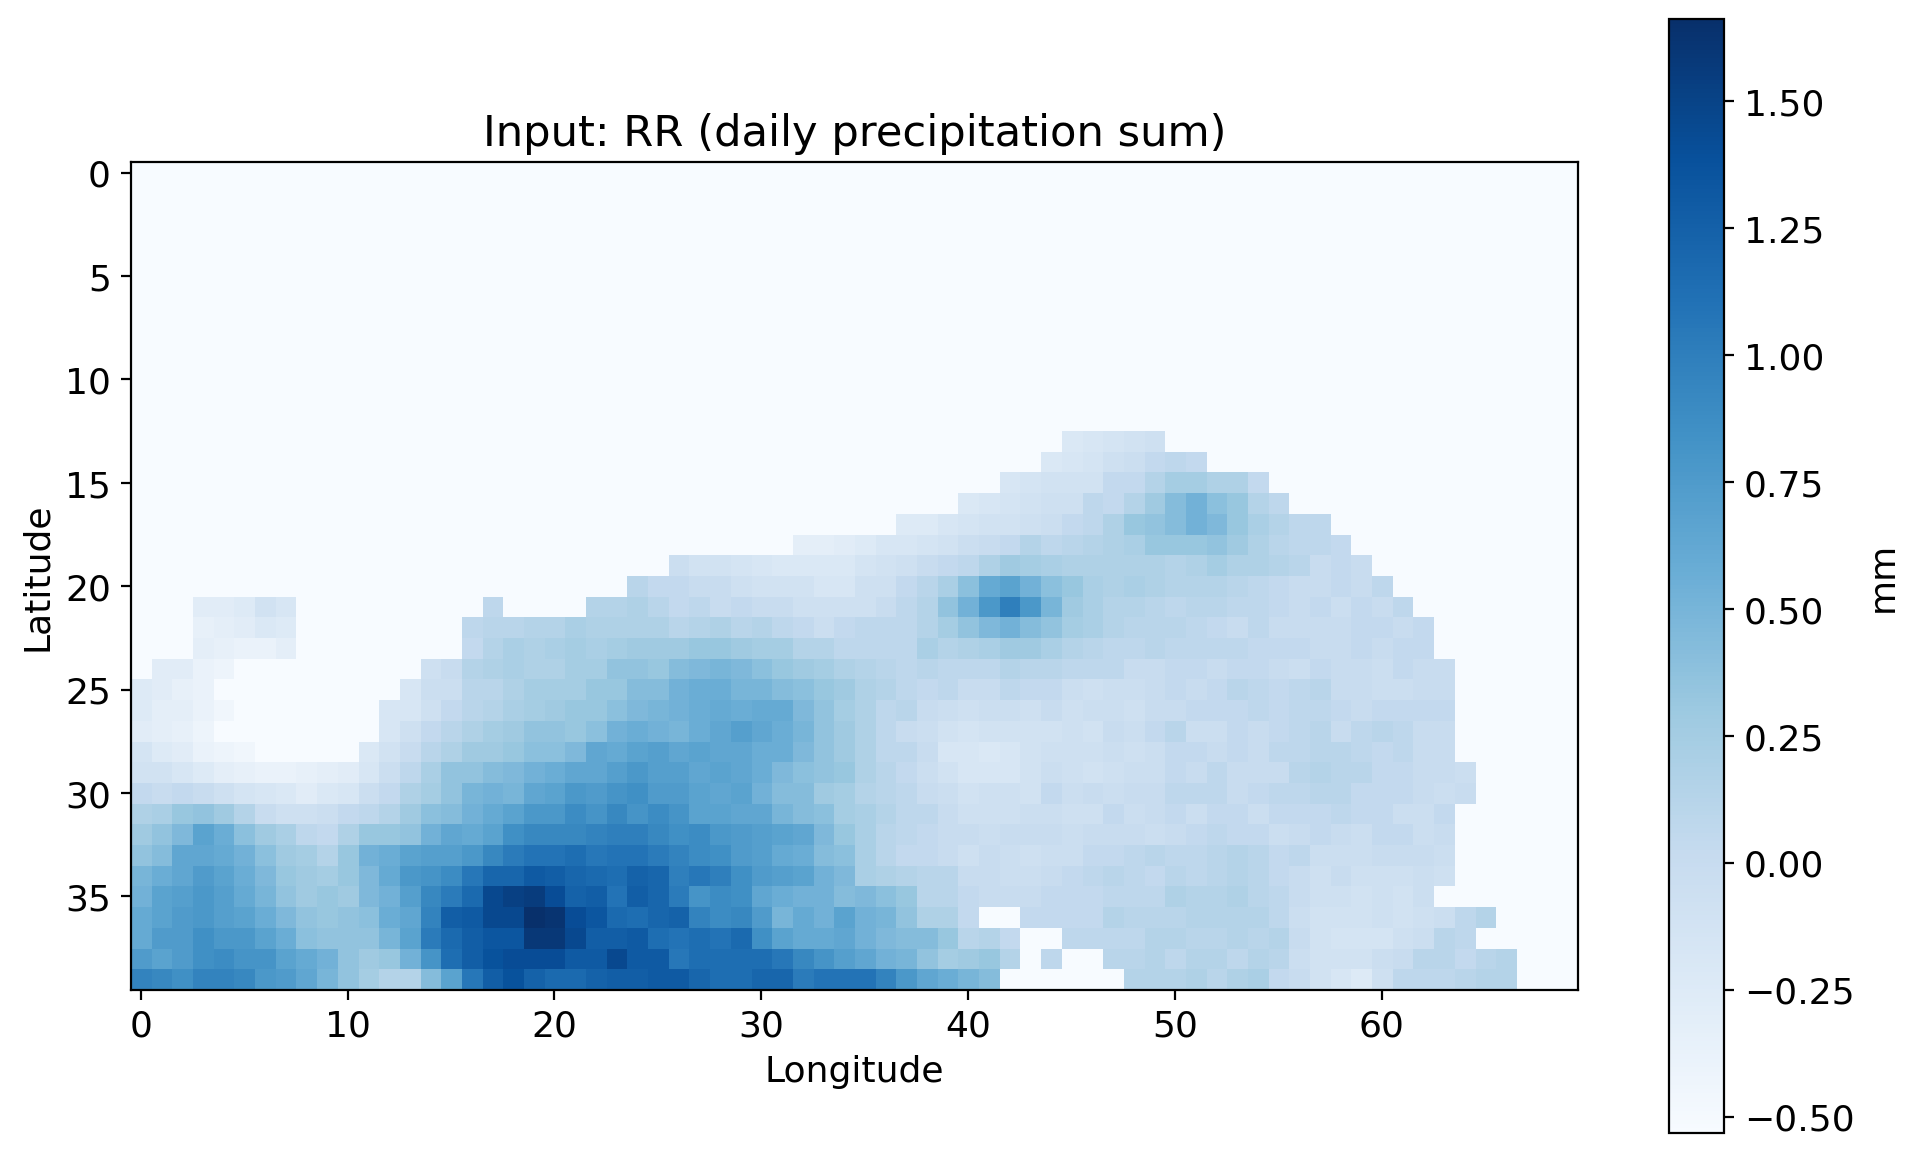

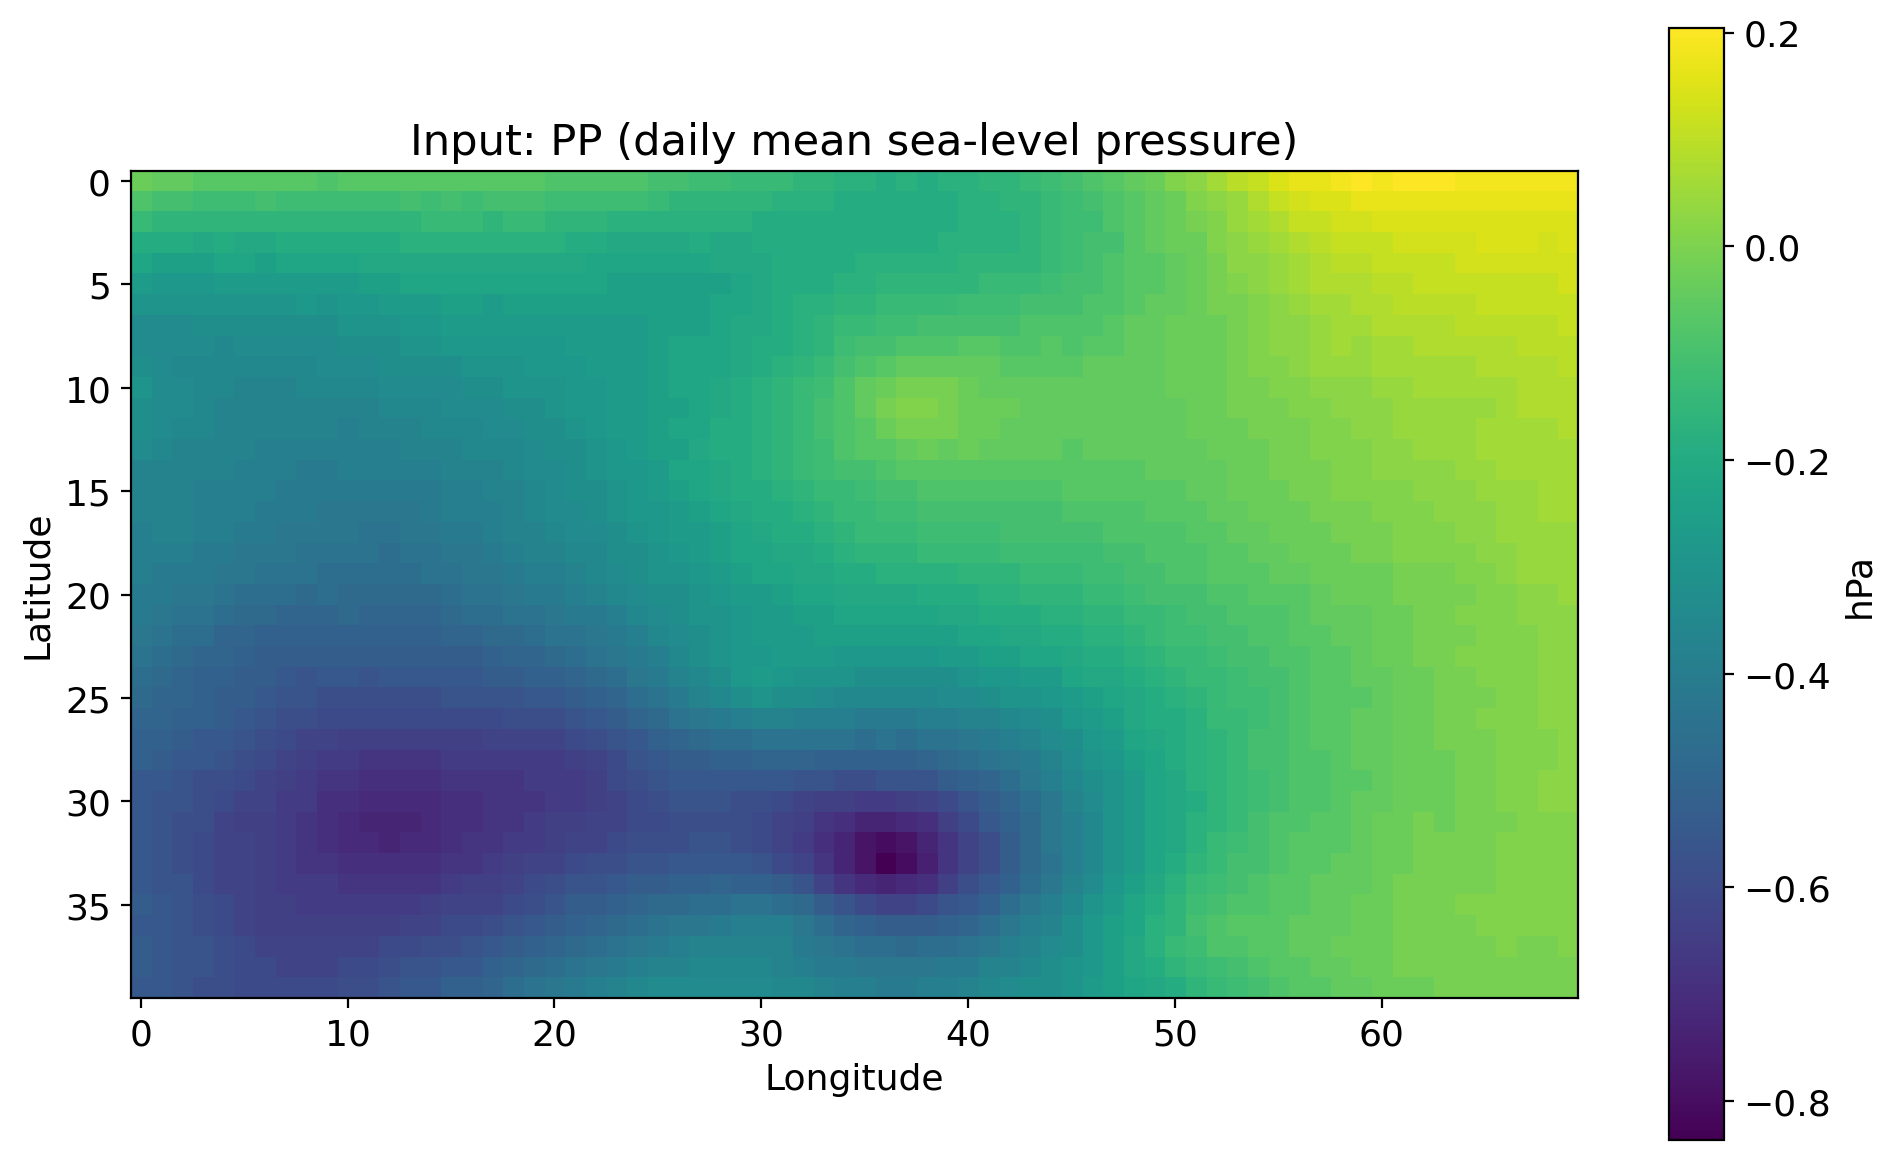

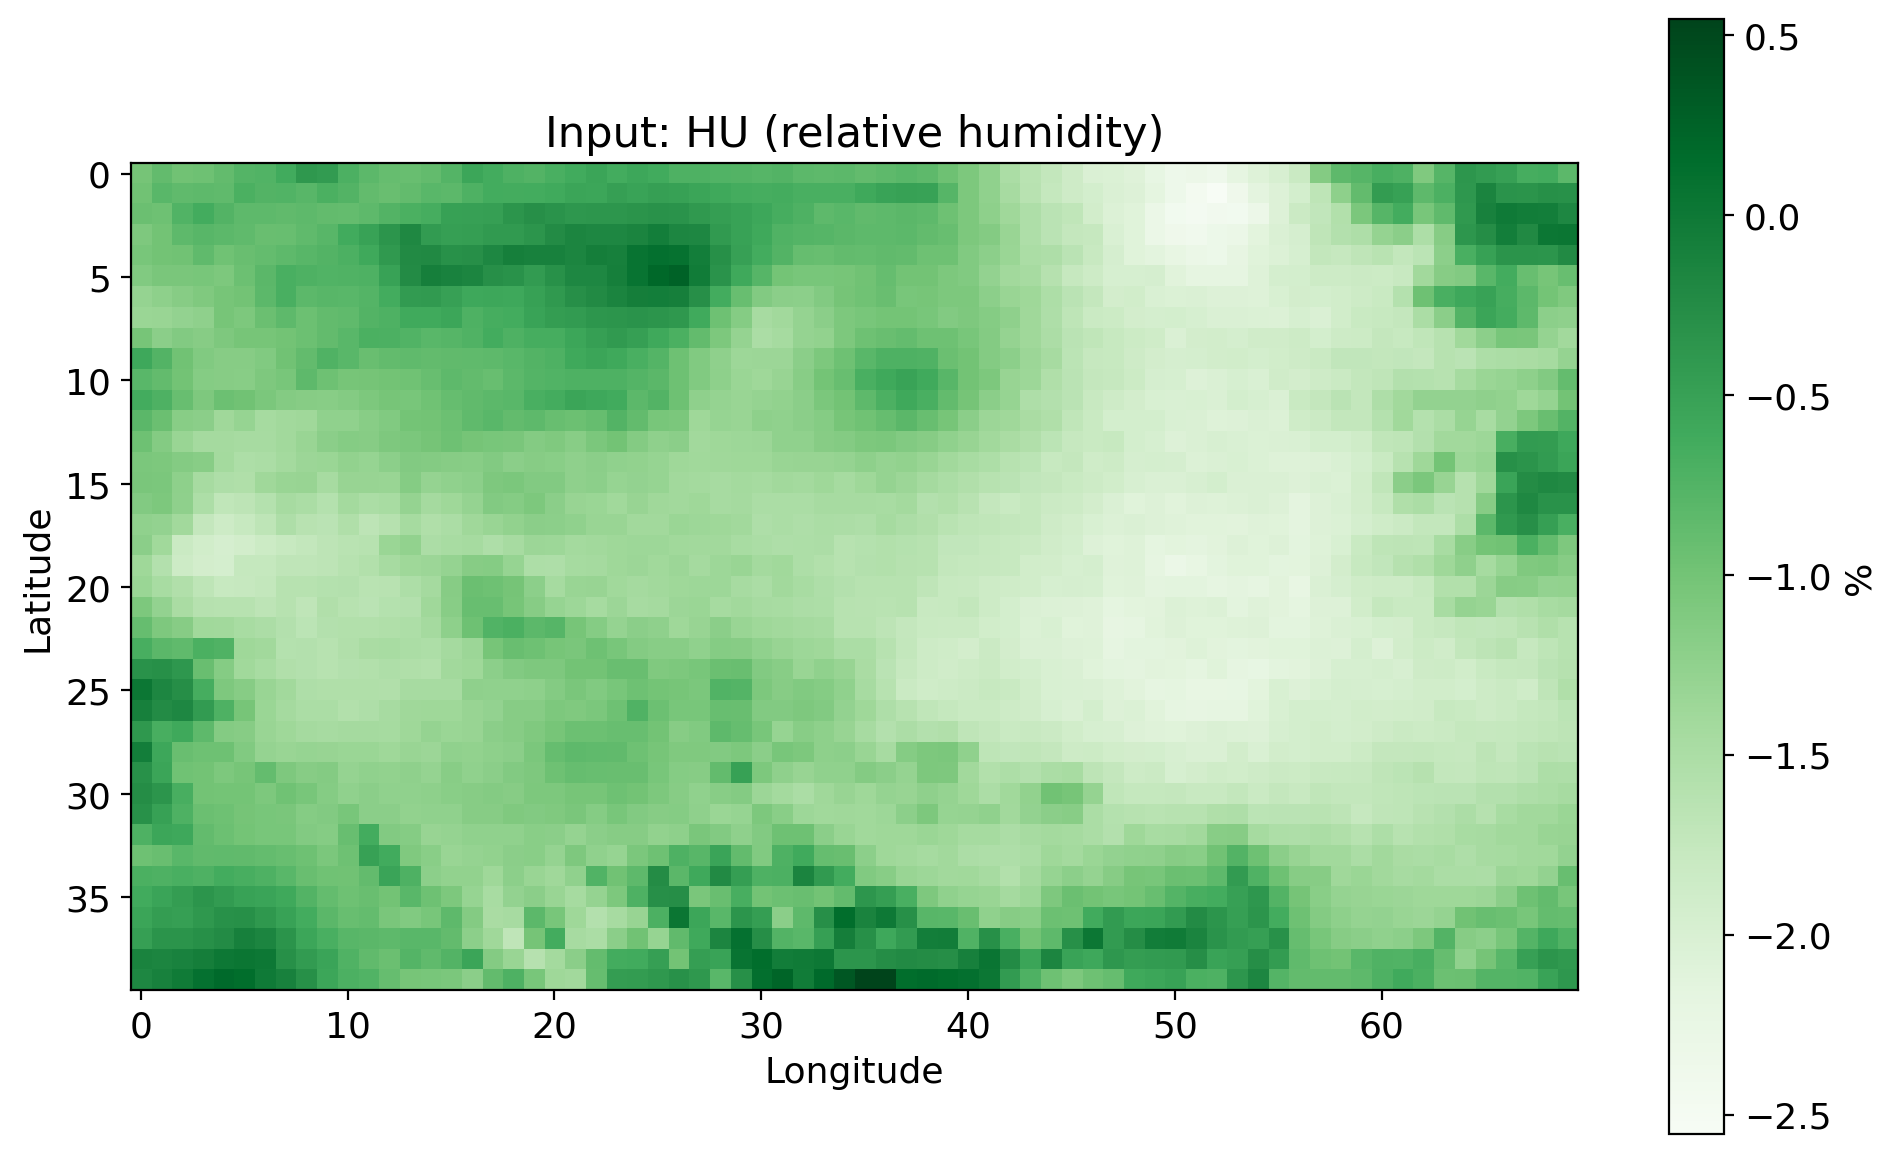

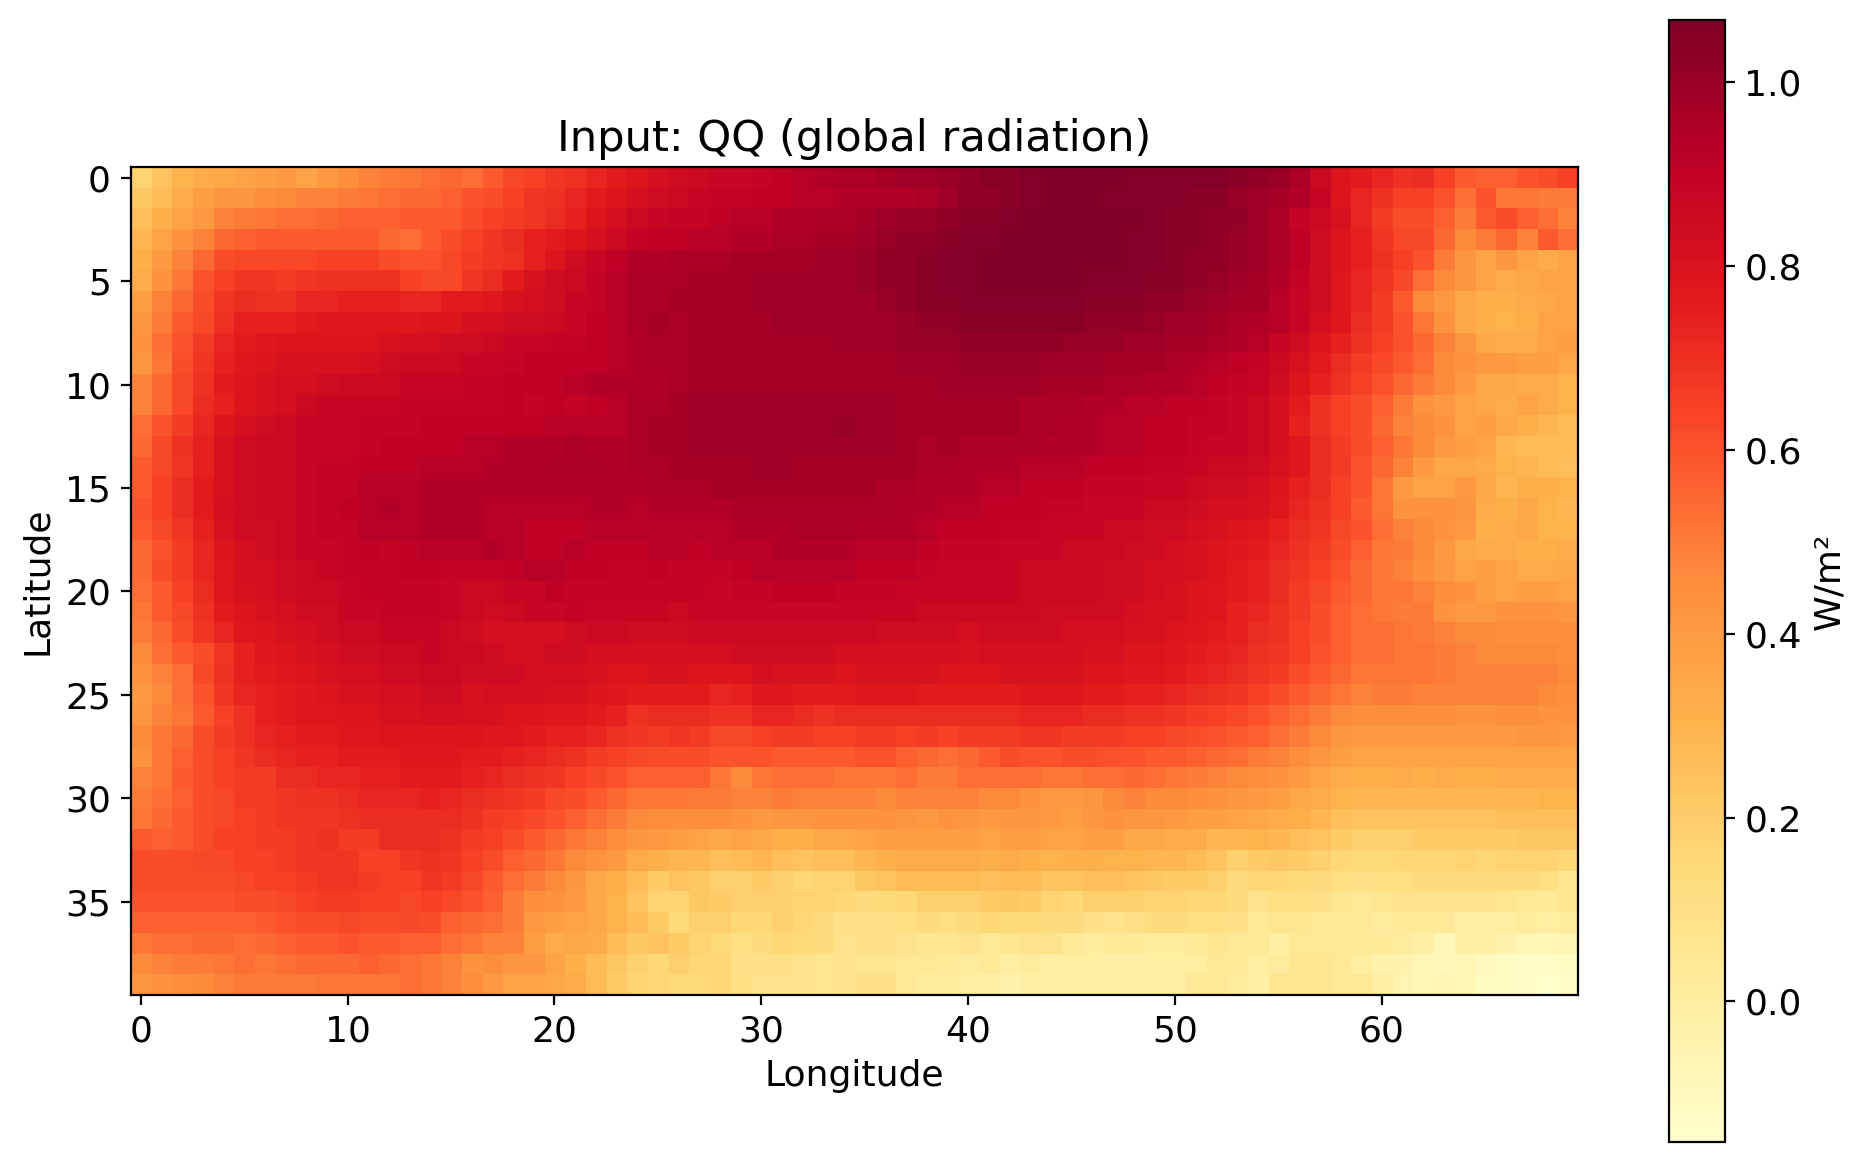

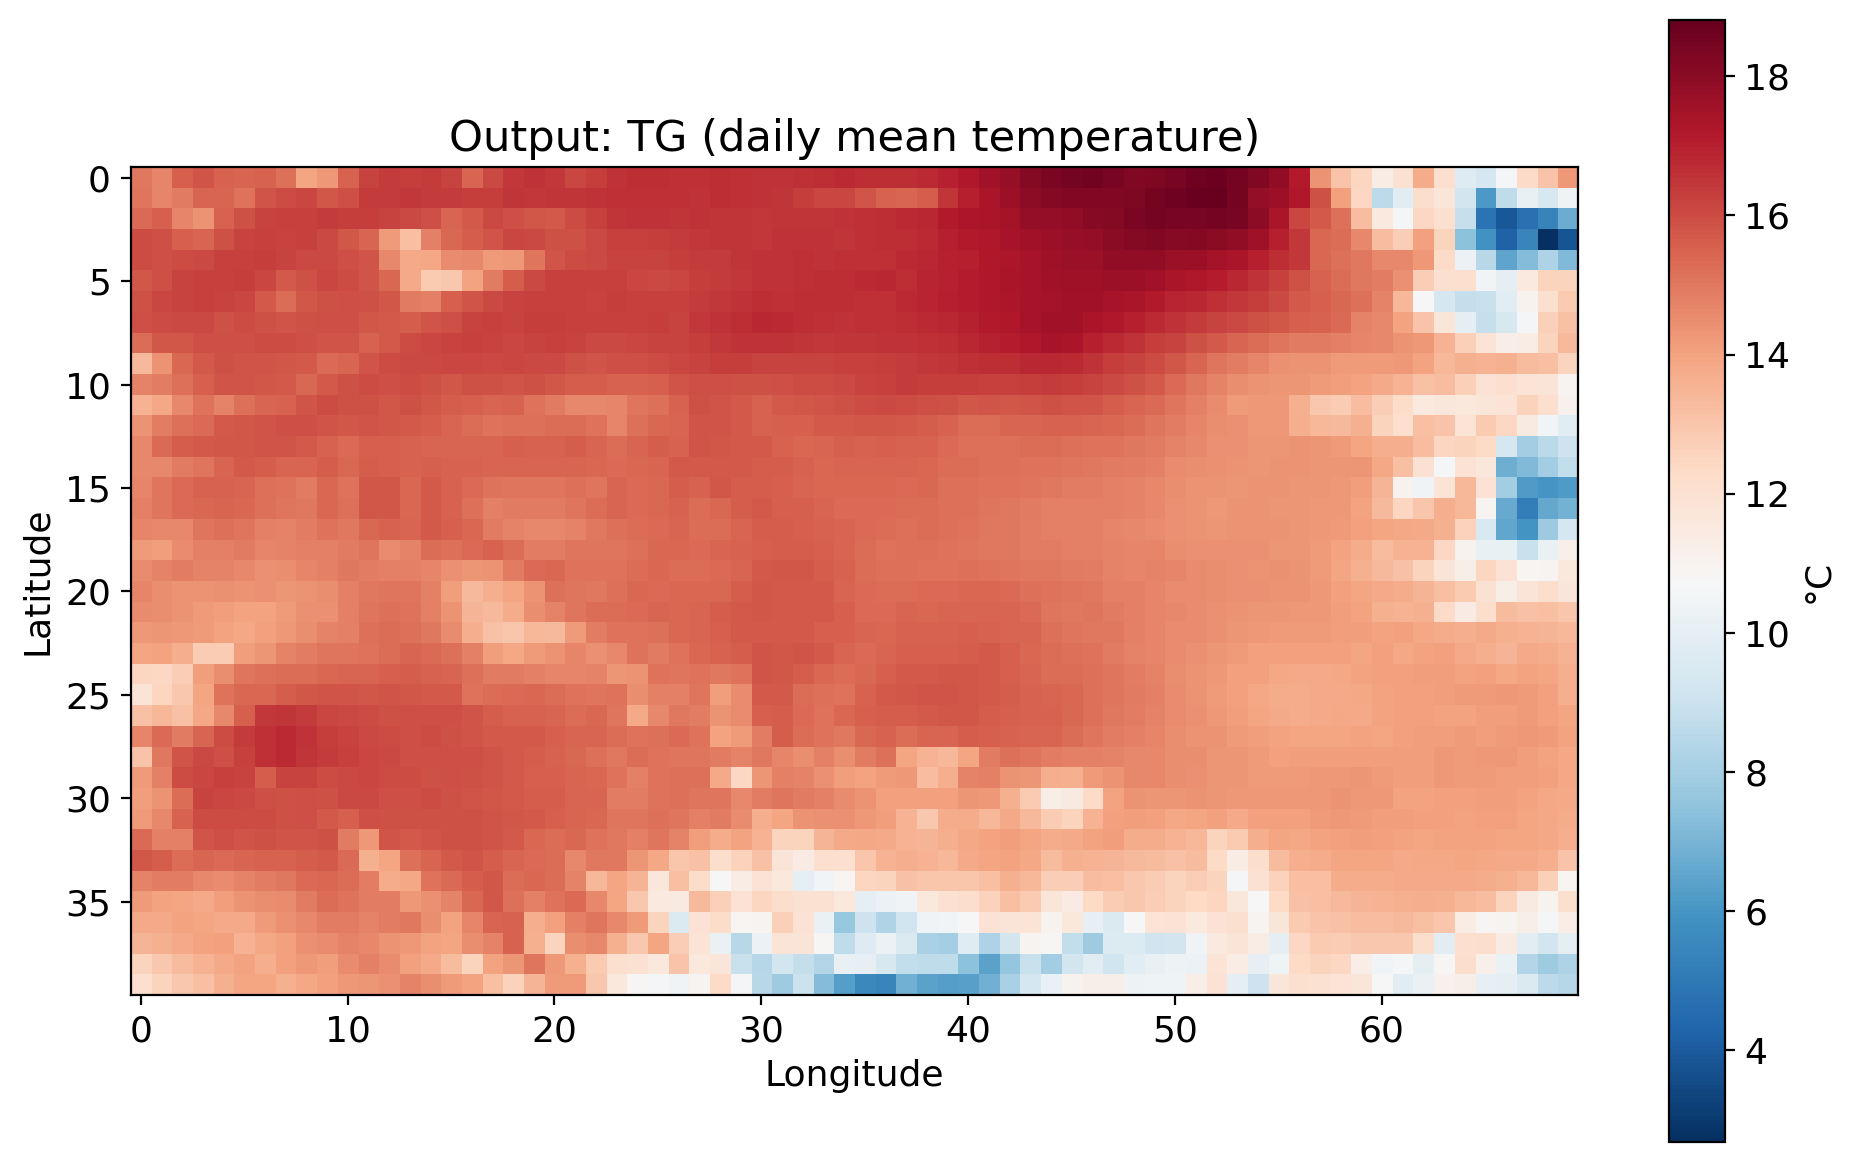

data range: 
**************************************************
RR (daily precipitation sum): [-0.53, 1.66]
**************************************************
PP (daily mean sea-level pressure): [-0.84, 0.20]
**************************************************
HU (relative humidity): [-2.56, 0.54]
**************************************************
QQ (global radiation): [-0.15, 1.07]
**************************************************
TG (temperature): [2.68, 18.81]


In [9]:
visualize_sample_data_separate()

In [10]:
n_filters     = 64
n_neurons     = 64
activation    = 'ReLU'
kernel_size   = 3
learning_rate = 0.001
minibatch_size = 128
num_epochs     = 100

In [11]:
def make_CNN_model(in_channels, n_filters, activation, kernel_size):
    Act = getattr(nn, activation)
    
    model = nn.Sequential(
        
        nn.Conv2d(in_channels, n_filters, kernel_size=kernel_size, padding=kernel_size//2),
        Act(),
        
        
        nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=kernel_size//2),
        Act(),
        
        
        nn.Conv2d(n_filters, n_filters, kernel_size=kernel_size, padding=kernel_size//2),
        Act(),
        
        
        nn.Conv2d(n_filters, 1, kernel_size=kernel_size, padding=kernel_size//2)
    )
    
    return model

In [12]:
model_mse = make_CNN_model(in_channels=4, n_filters=n_filters, activation=activation, kernel_size=kernel_size)

In [13]:
print("Model:")
print(model_mse)
print(f"\nTotal parameters: {sum(p.numel() for p in model_mse.parameters())}")

Model:
Sequential(
  (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

Total parameters: 76801


In [14]:
def train_model(model, train_loader, val_loader, optimizer, criterion, device):

    best_val_loss = float('inf')
    patience_counter = 0
    patience = 20
    
    train_losses = []
    val_losses = []

    model = model.to(device)

    for epoch in range(num_epochs):   

        model.train()
        running_train = 0.0

        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train += loss.item()

        train_loss = running_train / len(train_loader)


        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device).unsqueeze(1)

                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val += loss.item()

        val_loss = running_val / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
           best_val_loss = val_loss
           patience_counter = 0
        else:
           patience_counter += 1
           if patience_counter >= patience:
               print(f'Early stopping at epoch {epoch+1}')
               break

    return train_losses, val_losses


In [15]:
train_loader = data_dict['train_loader']
val_loader   = data_dict['val_loader']
test_loader  = data_dict['test_loader']

In [16]:
optimizer_mse = torch.optim.Adam(model_mse.parameters(), lr=learning_rate)
criterion_mse = nn.MSELoss()

train_losses_mse, val_losses_mse = train_model(
    model=model_mse,
    train_loader=train_loader,  
    val_loader=val_loader,
    optimizer=optimizer_mse,
    criterion=criterion_mse,
    device=device
)

Epoch 1/100, Train Loss: 163.9741, Val Loss: 189.7965
Epoch 2/100, Train Loss: 145.1583, Val Loss: 155.3989
Epoch 3/100, Train Loss: 112.0460, Val Loss: 97.0919
Epoch 4/100, Train Loss: 76.5556, Val Loss: 61.5132
Epoch 5/100, Train Loss: 50.0414, Val Loss: 51.9130
Epoch 6/100, Train Loss: 53.2290, Val Loss: 29.1423
Epoch 7/100, Train Loss: 29.0363, Val Loss: 28.1619
Epoch 8/100, Train Loss: 25.4221, Val Loss: 40.7241
Epoch 9/100, Train Loss: 31.6511, Val Loss: 47.7285
Epoch 10/100, Train Loss: 29.4364, Val Loss: 46.1717
Epoch 11/100, Train Loss: 29.5398, Val Loss: 41.1045
Epoch 12/100, Train Loss: 30.1470, Val Loss: 36.2719
Epoch 13/100, Train Loss: 27.8277, Val Loss: 31.2235
Epoch 14/100, Train Loss: 24.2276, Val Loss: 26.4927
Epoch 15/100, Train Loss: 20.9181, Val Loss: 23.5514
Epoch 16/100, Train Loss: 21.3097, Val Loss: 22.4853
Epoch 17/100, Train Loss: 19.4658, Val Loss: 21.8921
Epoch 18/100, Train Loss: 21.8986, Val Loss: 20.9759
Epoch 19/100, Train Loss: 19.0627, Val Loss: 20.35

In [17]:
def plot_history(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training History')
    plt.show()

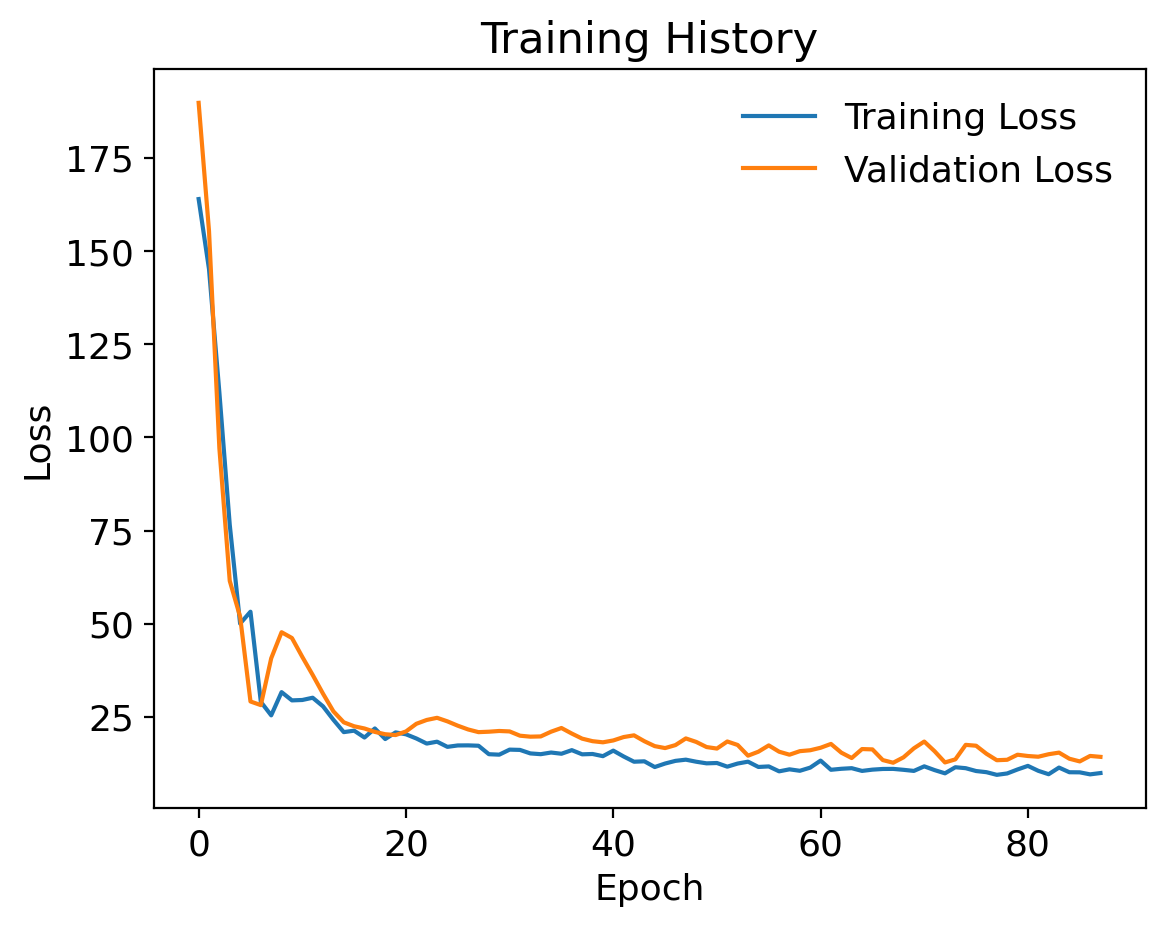

In [18]:
plot_history(train_losses_mse, val_losses_mse)

In [19]:
model_mae = make_CNN_model(in_channels=4, n_filters=n_filters, activation=activation, kernel_size=kernel_size)

In [20]:
# L1Loss = MAE
criterion_mae = nn.L1Loss(reduction='mean') 
optimizer_mae = torch.optim.Adam(model_mae.parameters(), lr=learning_rate)

train_losses_mae, val_losses_mae = train_model(
    model=model_mae,
    train_loader=train_loader,  
    val_loader=val_loader,
    optimizer=optimizer_mae,
    criterion=criterion_mae,
    device=device
)

Epoch 1/100, Train Loss: 12.5530, Val Loss: 13.5032
Epoch 2/100, Train Loss: 11.3379, Val Loss: 12.4936
Epoch 3/100, Train Loss: 10.5818, Val Loss: 10.1734
Epoch 4/100, Train Loss: 7.9286, Val Loss: 6.7761
Epoch 5/100, Train Loss: 5.8540, Val Loss: 5.8382
Epoch 6/100, Train Loss: 6.3622, Val Loss: 6.2226
Epoch 7/100, Train Loss: 5.6477, Val Loss: 4.7284
Epoch 8/100, Train Loss: 4.3842, Val Loss: 4.6638
Epoch 9/100, Train Loss: 4.3579, Val Loss: 5.5840
Epoch 10/100, Train Loss: 4.6429, Val Loss: 5.3085
Epoch 11/100, Train Loss: 4.4836, Val Loss: 4.6000
Epoch 12/100, Train Loss: 4.0530, Val Loss: 4.3846
Epoch 13/100, Train Loss: 4.1864, Val Loss: 4.1208
Epoch 14/100, Train Loss: 3.9418, Val Loss: 3.8786
Epoch 15/100, Train Loss: 3.6211, Val Loss: 4.0744
Epoch 16/100, Train Loss: 3.6750, Val Loss: 4.0719
Epoch 17/100, Train Loss: 3.7428, Val Loss: 3.7432
Epoch 18/100, Train Loss: 3.7045, Val Loss: 3.6392
Epoch 19/100, Train Loss: 3.5701, Val Loss: 3.6615
Epoch 20/100, Train Loss: 3.6244, 

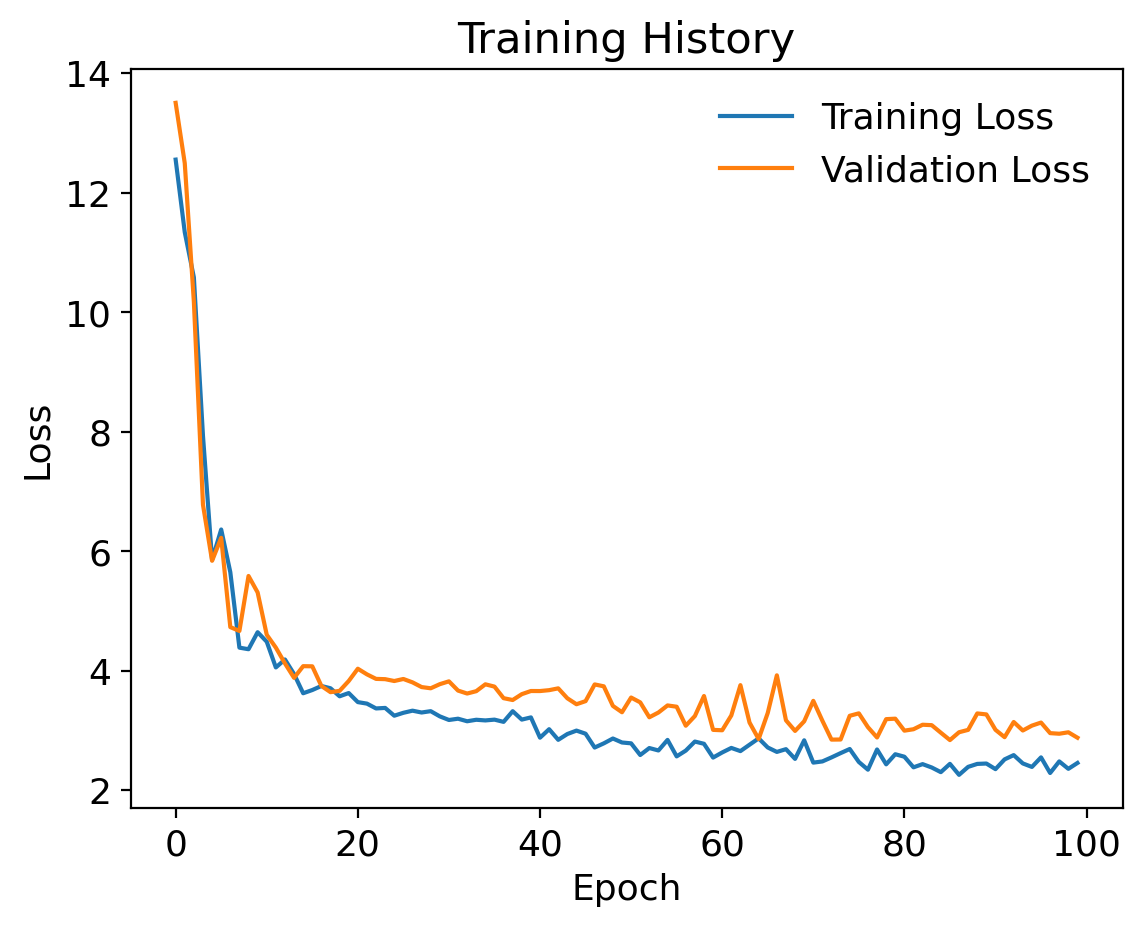

In [21]:
plot_history(train_losses_mae, val_losses_mae)

In [22]:
def make_dir(path):
    if os.path.exists(path) is False:
        os.makedirs(path)

In [23]:
model_path = os.path.join(cwd, 'saved_model')
make_dir(model_path)

In [24]:
torch.save(model_mse.state_dict(), os.path.join(model_path, 'CNN_model_mse_weights.pth'))
torch.save(model_mae.state_dict(), os.path.join(model_path, 'CNN_model_mae_weights.pth'))

In [25]:
#make new model instance for evaluation(best parctice)
model_mse_eval = make_CNN_model(in_channels=4, n_filters=n_filters, activation=activation, kernel_size=kernel_size)
model_mae_eval = make_CNN_model(in_channels=4, n_filters=n_filters, activation=activation, kernel_size=kernel_size)

# reload the saved model weights
state_dict_mse = torch.load(os.path.join(model_path,'CNN_model_mse_weights.pth'), weights_only=True)
model_mse_eval.load_state_dict(state_dict_mse)

state_dict_mae = torch.load(os.path.join(model_path,'CNN_model_mae_weights.pth'), weights_only=True)
model_mae_eval.load_state_dict(state_dict_mae)


<All keys matched successfully>

In [26]:
model_mse_eval.to(device).eval()

predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:      
        batch_X = batch_X.to(device)
        outputs = model_mse_eval(batch_X)         
        predictions.append(outputs.cpu().numpy())

y_test_mse_pre = np.concatenate(predictions, axis=0)  
y_test_mse_pre = y_test_mse_pre[:, 0, :, :]               

y_test_mse_pre = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude']
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test_mse_pre)
    )
)





model_mae_eval.to(device).eval()

predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:      
        batch_X = batch_X.to(device)
        outputs = model_mae_eval(batch_X)         
        predictions.append(outputs.cpu().numpy())

y_test_mae_pre = np.concatenate(predictions, axis=0)  
y_test_mae_pre = y_test_mae_pre[:, 0, :, :]               

y_test_mae_pre = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude']
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test_mae_pre)
    )
)

In [27]:
y_test_tensor = data_dict['test_loader'].dataset.tensors[1] 
y_test = y_test_tensor.numpy()

y_test_xr = xr.Dataset(
    coords={
        'time': data_dict['time_test'],
        'latitude': data_dict['spatial_info']['latitude'],
        'longitude': data_dict['spatial_info']['longitude'],
    },
    data_vars=dict(
        tg=(['time', 'latitude', 'longitude'], y_test)
    )
)


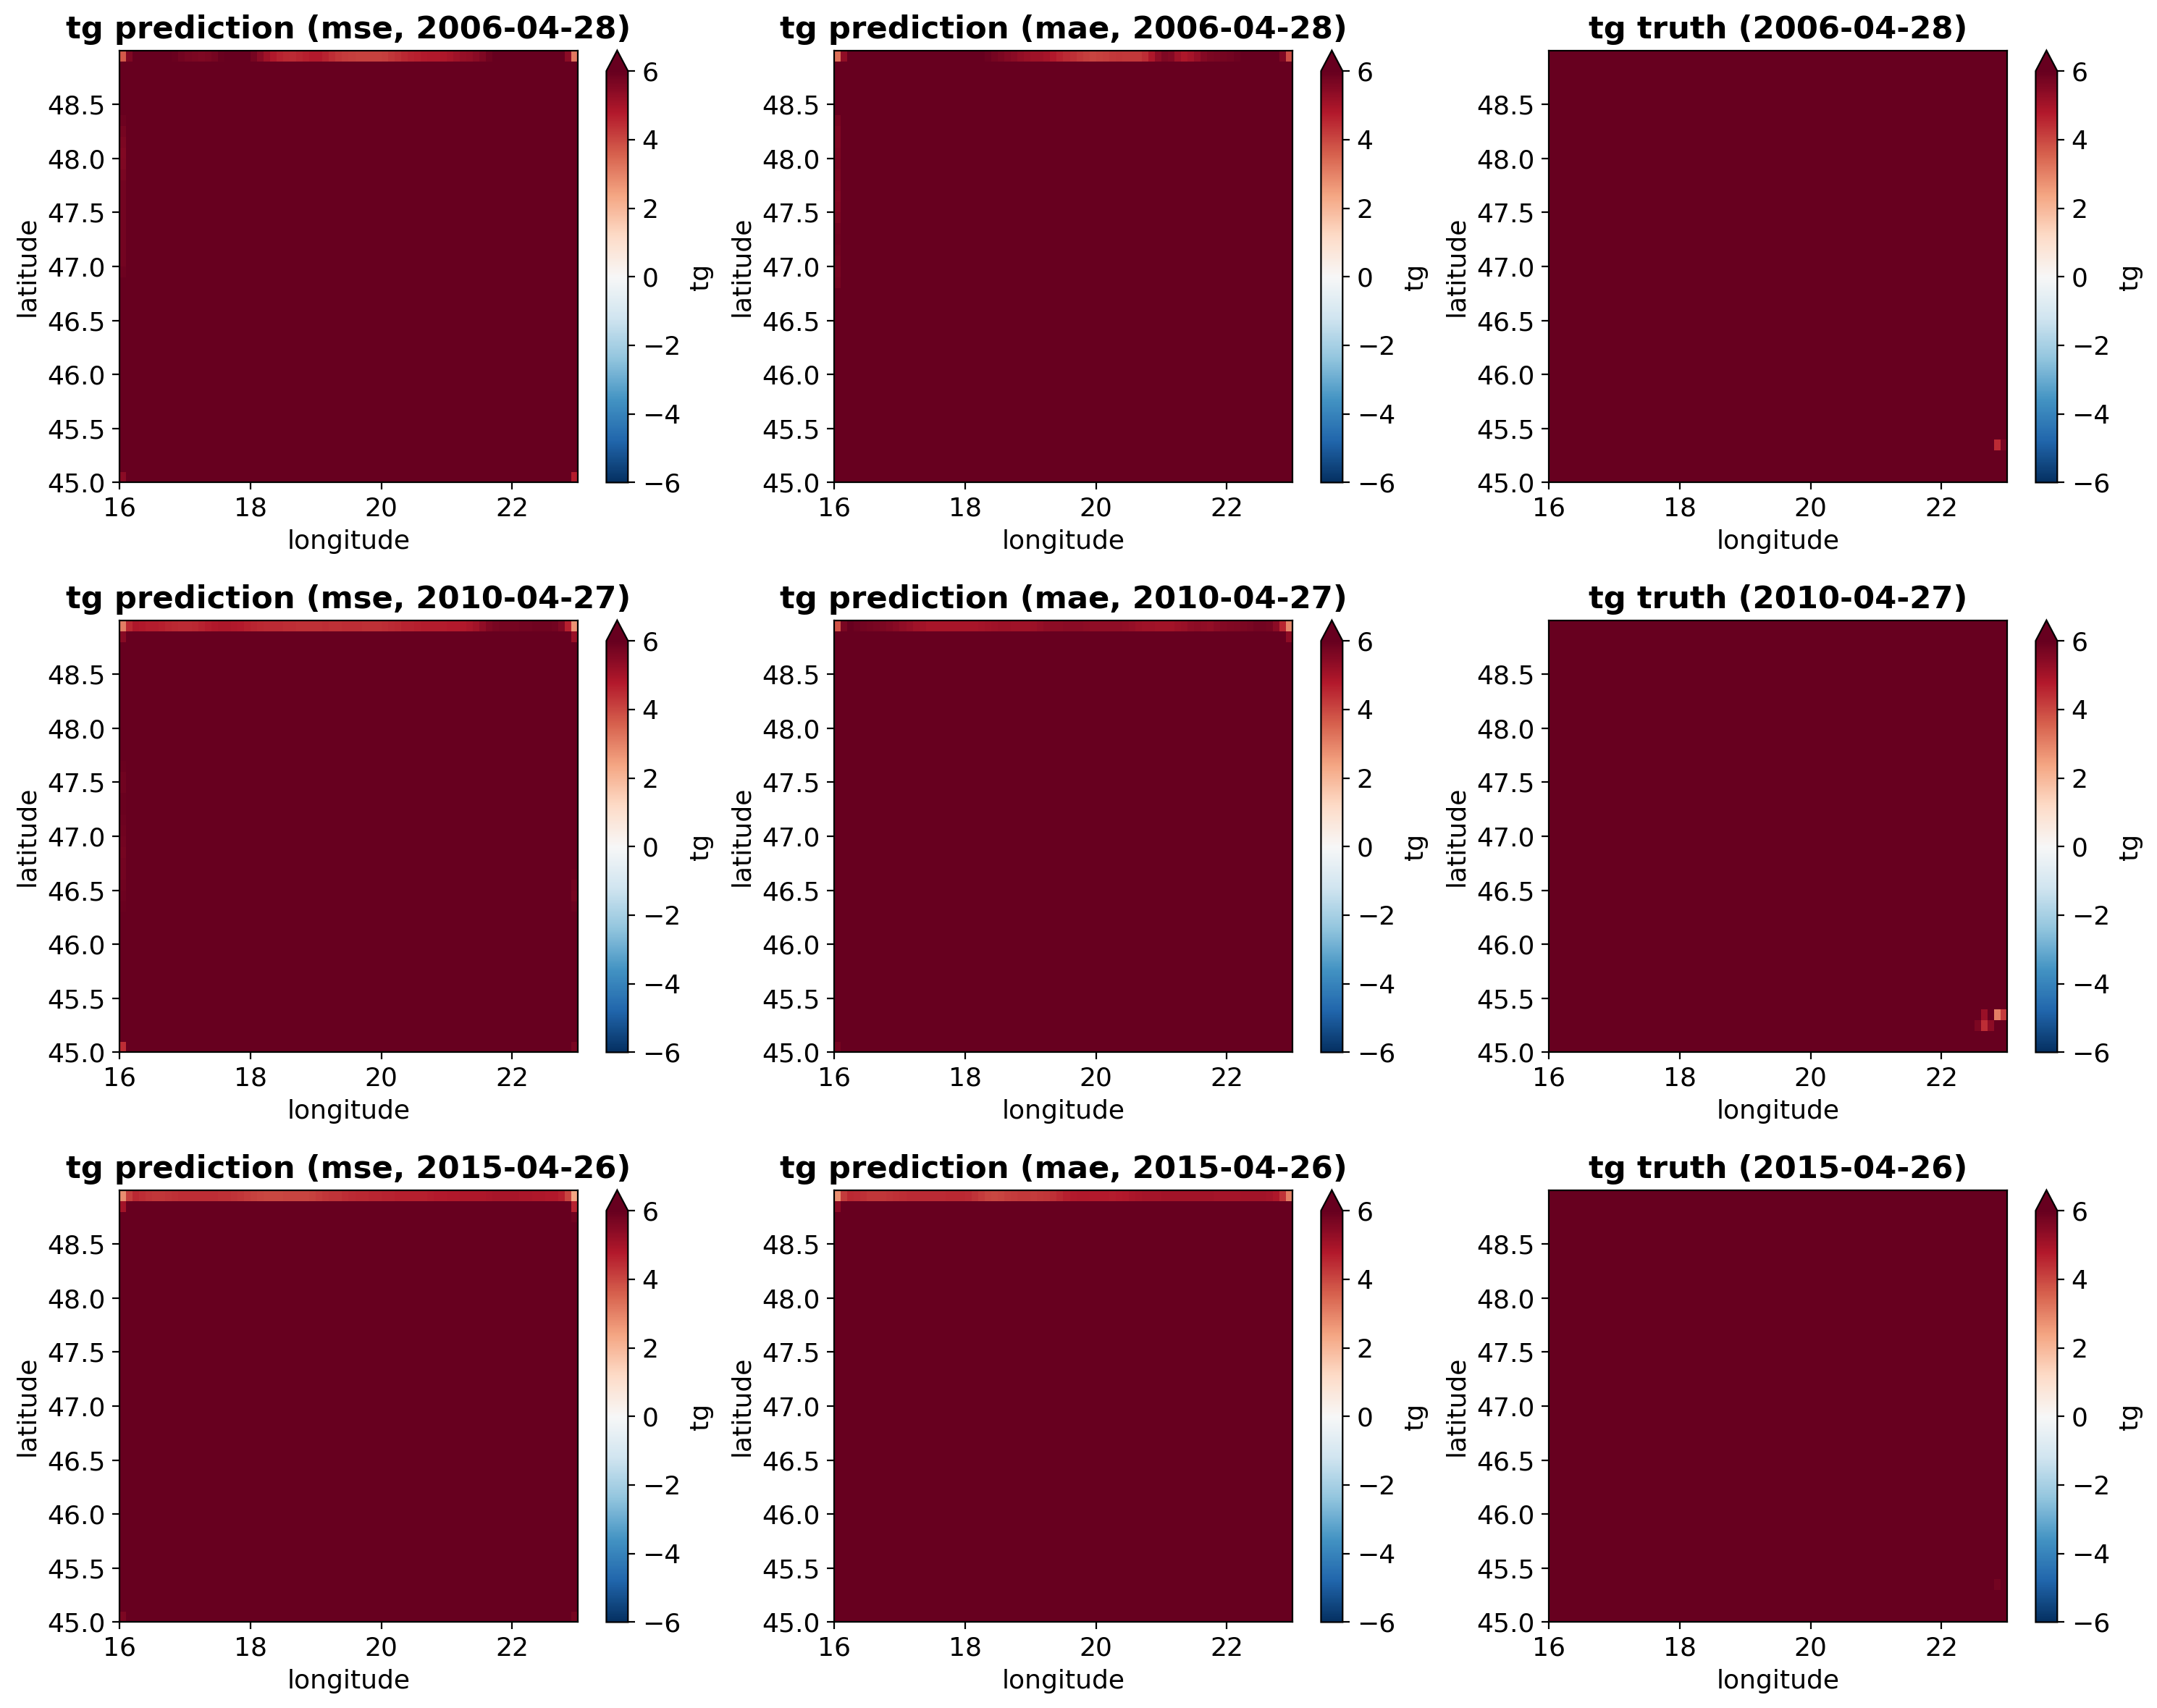

In [28]:
fig, axes = plt.subplots(figsize=(15, 12), ncols=3, nrows=3)

yrs = [
    '2006-04-28T00:00:00.000000000',
    '2010-04-27T00:00:00.000000000',
    '2015-04-26T00:00:00.000000000',
]

vmin, vmax = -6, 6
cmap = 'RdBu_r'

y_test_mse_pre.tg.sel(time=yrs[0]).plot(ax=axes[0, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_mae_pre.tg.sel(time=yrs[0]).plot(ax=axes[0, 1], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[0]).plot(ax=axes[0, 2], vmin=vmin, vmax=vmax, cmap=cmap)

y_test_mse_pre.tg.sel(time=yrs[1]).plot(ax=axes[1, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_mae_pre.tg.sel(time=yrs[1]).plot(ax=axes[1, 1], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[1]).plot(ax=axes[1, 2], vmin=vmin, vmax=vmax, cmap=cmap)


y_test_mse_pre.tg.sel(time=yrs[2]).plot(ax=axes[2, 0], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_mae_pre.tg.sel(time=yrs[2]).plot(ax=axes[2, 1], vmin=vmin, vmax=vmax, cmap=cmap)
y_test_xr.tg.sel(time=yrs[2]).plot(ax=axes[2, 2], vmin=vmin, vmax=vmax, cmap=cmap)


for i, ax in enumerate(axes.flat):
    
    if i % 3 == 0:
        ax.set_title(f'tg prediction (mse, {yrs[i//3][:10]})', fontweight='bold')
    
    elif i % 3 == 1:
        ax.set_title(f'tg prediction (mae, {yrs[i//3][:10]})', fontweight='bold')
    
    else:
        ax.set_title(f'tg truth ({yrs[i//3][:10]})', fontweight='bold')

plt.tight_layout()
plt.show()


Text(0, 0.5, 'temperature (°C)')

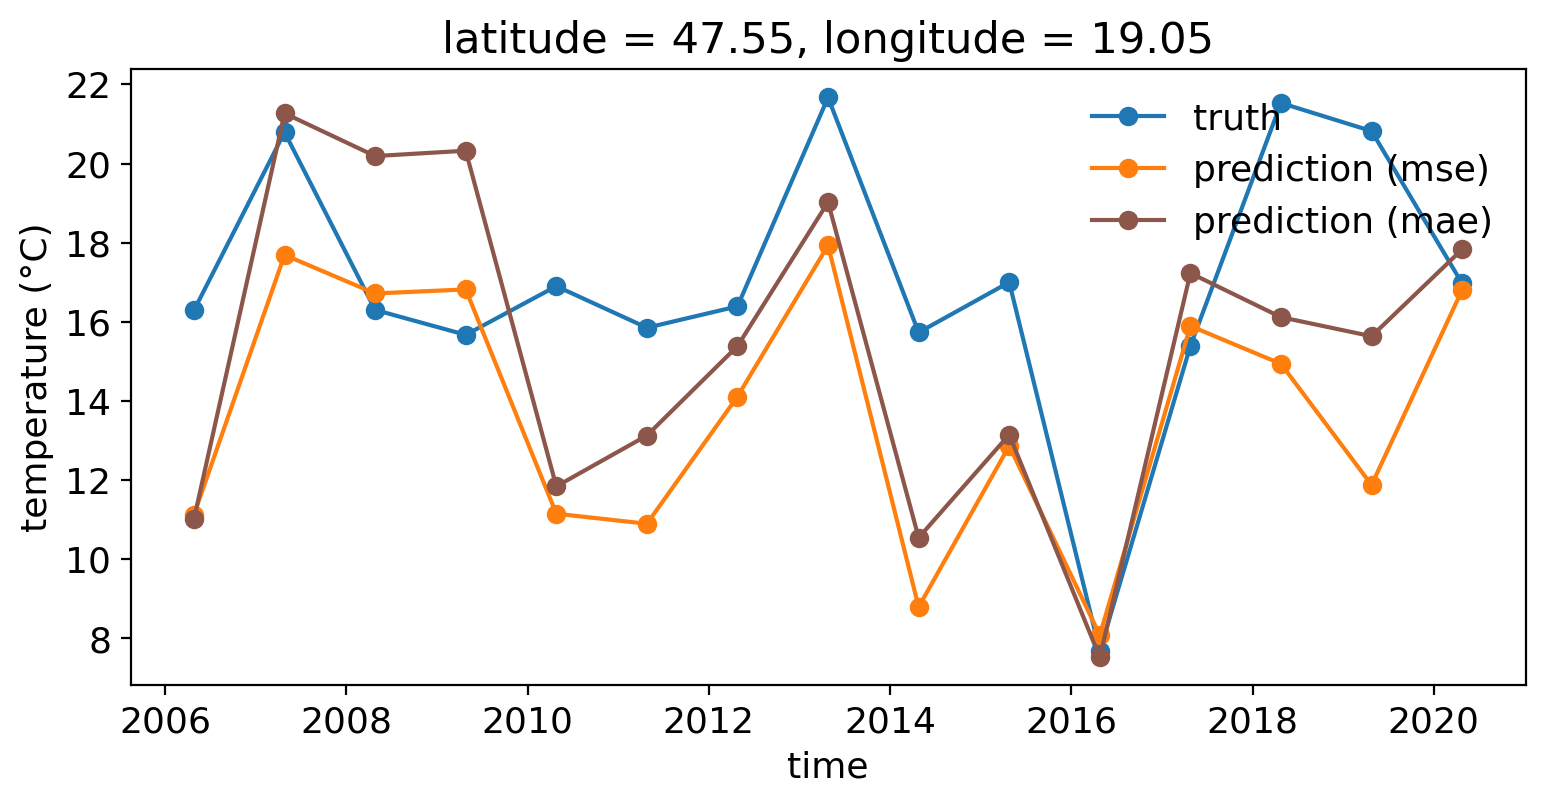

In [29]:
#Budapest
lat = 47.5
lon = 19.0

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('temperature (°C)')

In [30]:
# combine truth and prediction arrays into a dataframe
bud_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.values
bud_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.values
bud_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tg.values

df_bud_test = pd.DataFrame()
df_bud_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_bud_test["truth"] = bud_test_xr
df_bud_test["prediction_mse"] = bud_test_mse_pre
df_bud_test["prediction_mae"] = bud_test_mae_pre
print(df_bud_test.head(10))

# summary statistics of the dataframe
df_bud_test.describe()

        time      truth  prediction_mse  prediction_mae
0 2006-04-28  16.289999       11.124345       11.013821
1 2007-04-28  20.789999       17.689493       21.269632
2 2008-04-27  16.299999       16.715971       20.188751
3 2009-04-27  15.670000       16.818096       20.323423
4 2010-04-27  16.900000       11.148997       11.840893
5 2011-04-27  15.849999       10.895800       13.125445
6 2012-04-26  16.389999       14.109849       15.385193
7 2013-04-26  21.670000       17.931297       19.022827
8 2014-04-26  15.730000        8.793206       10.542970
9 2015-04-26  17.000000       12.863853       13.148508


,time,truth,prediction_mse,prediction_mae
count,15,15.000000,15.000000,15.000000
mean,2013-04-26 00:00:00,16.998665,13.711902,15.346000
min,2006-04-28 00:00:00,7.680000,8.078223,7.517058
25%,2009-10-26 12:00:00,15.789999,11.136671,12.483169
50%,2013-04-26 00:00:00,16.389999,14.109849,15.634630
75%,2016-10-24 12:00:00,18.895000,16.759953,18.426675
max,2020-04-24 00:00:00,21.670000,17.931297,21.269632
std,NaN,3.451937,3.267711,4.074399


In [31]:
def area_mean_std_plot(X,label,color,ax,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tg_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tg_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tg_mean+tg_std,tg_mean-tg_std,facecolor=color,alpha=0.2)


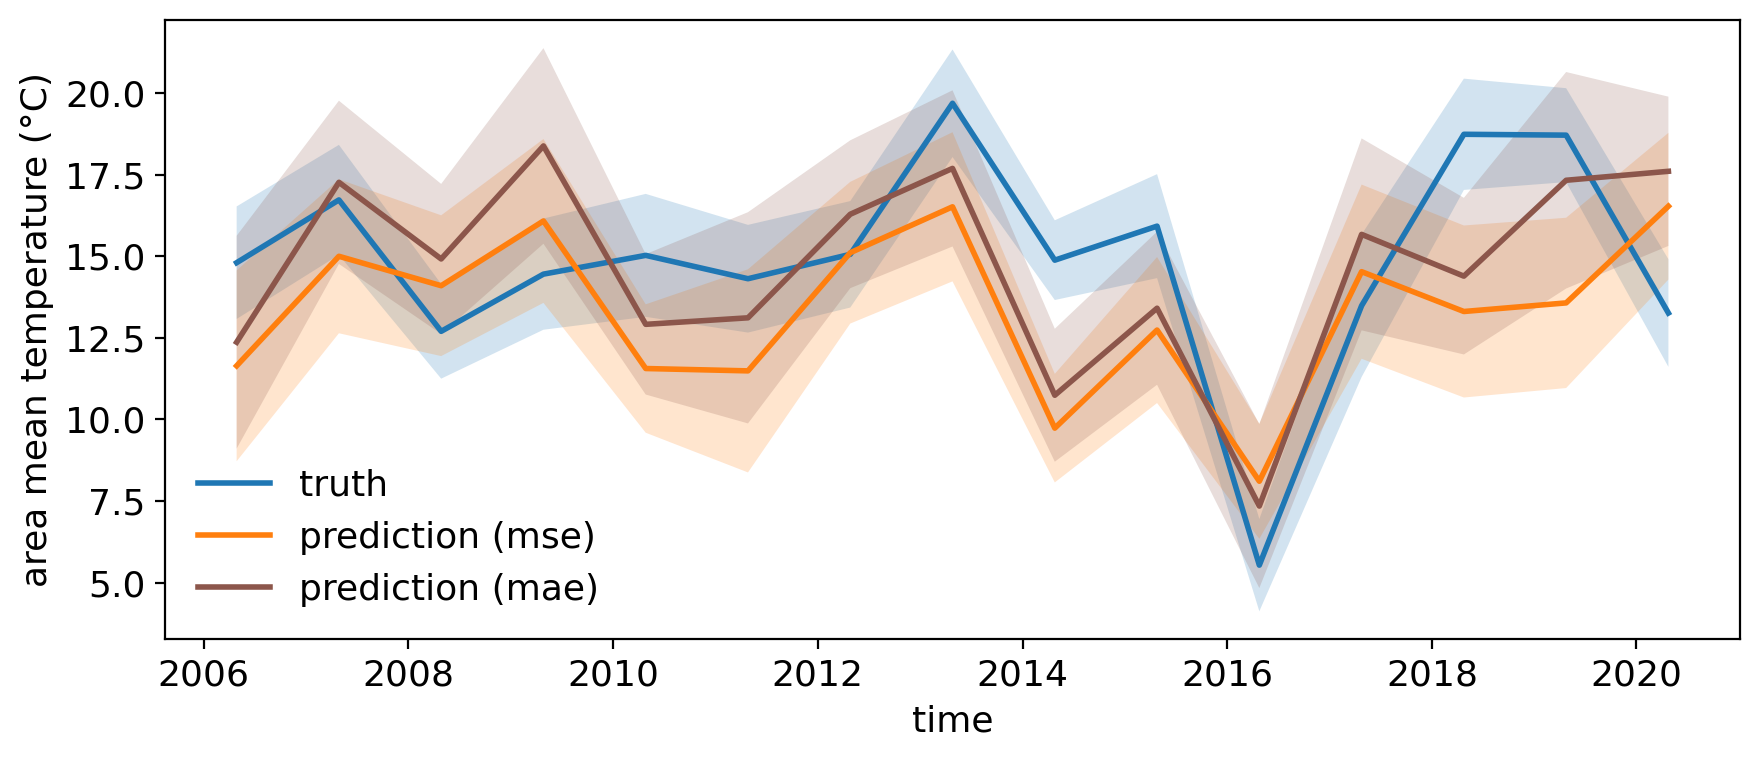

In [32]:
fig,ax = plt.subplots(figsize=(9,4))

area_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
area_mean_std_plot(y_test_mse_pre,label='prediction (mse)',ax=ax,color='tab:orange')
area_mean_std_plot(y_test_mae_pre,label='prediction (mae)',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('area mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [33]:
# get area mean temperature
def area_mean(X,var='tg'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tg_mean = X['tg'].weighted(weights).mean(['latitude', 'longitude']).data
    return tg_mean

tg_mean_xr = area_mean(y_test_xr)
tg_mean_mse_pre = area_mean(y_test_mse_pre)
tg_mean_mae_pre = area_mean(y_test_mae_pre)

# put into dataframe
df_area_test = pd.DataFrame()
df_area_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tg.to_dataframe().index
df_area_test["truth"] = tg_mean_xr
df_area_test["prediction_mse"] = tg_mean_mse_pre
df_area_test["prediction_mae"] = tg_mean_mae_pre
print(df_area_test.head(10))

# summary statistics of the dataframe
df_area_test.describe()

        time      truth  prediction_mse  prediction_mae
0 2006-04-28  14.803944       11.644002       12.367661
1 2007-04-28  16.727935       15.001042       17.267306
2 2008-04-27  12.701073       14.099152       14.918751
3 2009-04-27  14.453840       16.083376       18.381570
4 2010-04-27  15.028954       11.561507       12.915215
5 2011-04-27  14.312991       11.489638       13.115325
6 2012-04-26  15.060781       15.110179       16.288550
7 2013-04-26  19.689338       16.516975       17.693624
8 2014-04-26  14.881740        9.734740       10.742646
9 2015-04-26  15.924609       12.740995       13.409342


,time,truth,prediction_mse,prediction_mae
count,15,15.000000,15.000000,15.000000
mean,2013-04-26 00:00:00,14.888037,13.335671,14.629670
min,2006-04-28 00:00:00,5.536672,8.107955,7.346624
25%,2009-10-26 12:00:00,13.899489,11.602754,13.015270
50%,2013-04-26 00:00:00,14.881740,13.572443,14.918751
75%,2016-10-24 12:00:00,16.326272,15.055611,17.298604
max,2020-04-24 00:00:00,19.689338,16.535288,18.381570
std,NaN,3.320768,2.477918,3.053484


In [34]:
rmse_bud_mse_test_default = np.sqrt(mean_squared_error(bud_test_xr, bud_test_mse_pre))

print(f"RMSE_mse for Budapest: {rmse_bud_mse_test_default}")

rmse_bud_mae_test_default = np.sqrt(mean_squared_error(bud_test_xr, bud_test_mae_pre))

print(f"RMSE_mae for Budapest: {rmse_bud_mae_test_default}")

RMSE_mse for Budapest: 4.4997992515563965
RMSE_mae for Budapest: 3.7234654426574707


In [35]:
rmse_mse_test_default = np.sqrt(mean_squared_error(tg_mean_xr, tg_mean_mse_pre))

print(f"RMSE_mse for area: {rmse_mse_test_default}")

rmse_mae_test_default = np.sqrt(mean_squared_error(tg_mean_xr, tg_mean_mae_pre))

print(f"RMSE_mae for area: {rmse_mae_test_default}")

RMSE_mse for area: 3.2515541884155628
RMSE_mae for area: 2.6975276301496143
